In [326]:
using CSV, DataFrames
using FileIO, Dates
using DelimitedFiles

using Plots; gr()
using StatsBase
using LinearAlgebra

using CurveFit

include("../region_cube_split/cubes.jl")
include("./motifs_analysis.jl")

volume_tetrahedrons (generic function with 1 method)

In [162]:
romania_full = CSV.read("../data/romania.csv", DataFrame);
romania = romania_full[romania_full.Datetime .> DateTime(1976,1,1,0,0,0),:];

vrancea = romania[(romania.Latitude .>= 45.20) .& (romania.Latitude .<= 46.0) .& 
                    (romania.Longitude .>= 26.0) .& (romania.Longitude .<= 27.0) .&
                    (romania.Depth .>= 50.0) .& (romania.Depth .<= 200.0), :];

In [163]:
vrancea, vrancea_cubes = region_cube_split(vrancea,side=5,energyRelease=true);

In [164]:
motif = "Triangle"
# motif = "Tetrahedron"

"Triangle"

In [165]:
filename= "./motifs" * motif * "_vrancea_5km.csv"
motifs = readdlm(filename, ',', Int64);
motifs;

In [166]:
motif_energy = total_mean_energy(motifs, vrancea, vrancea_cubes);
areas = area_triangles(motifs, vrancea_cubes);

### Tetrahedron test . \passed

In [167]:
# # motif = "Triangle"
# motif = "Tetrahedron"
# filename= "./motifs" * motif * "_vrancea_5km.csv"
# motifs = readdlm(filename, ',', Int64);
# motifs;
# motif_energy = total_mean_energy(motifs, vrancea, vrancea_cubes)
# volumes = volume_tetrahedrons(motifs,vrancea_cubes)

In [170]:
area = [value for value in values(areas)];
totalenergy = [value[1] for value in values(motif_energy)]
meanenergy = [value[2] for value in values(motif_energy)];

## Imposing a limit for acceptables areas

In [222]:
area_weight_totalenergy = []
area_weight_meanenergy = []
for key in keys(motif_energy)
    # Used to filter out zeros and very small areas (triangles on the vertical for example)
    if areas[key] > 1
        push!(area_weight_totalenergy, areas[key]/motif_energy[key][1])
        push!(area_weight_meanenergy, areas[key]/motif_energy[key][2])
    end
end

In [213]:
area

2312-element Vector{Float64}:
  21.312063027848378
  35.59185979590338
 162.47041141758646
  40.303658999363165
 310.78291529411734
  99.01964041424233
  97.57440402368121
  78.95730022852459
 828.1716588447175
  89.40446577610383
   ⋮
 364.27324524829527
 173.71076259057364
 178.2077260481152
 224.29661787156826
  34.082447062689006
 302.0165227592023
 155.25419318256962
 347.8191368711288
 269.3305692115957

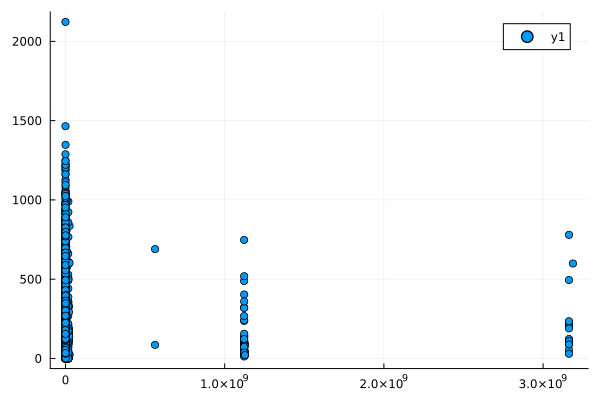

In [214]:
scatter(totalenergy,area)

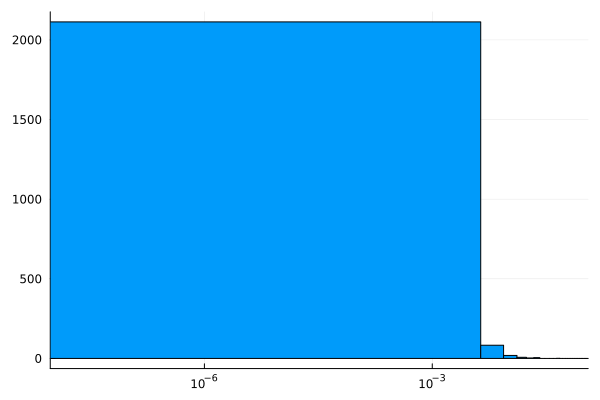

In [224]:
b = range(minimum(area_weight_totalenergy), 
        stop = maximum(area_weight_totalenergy), 
        length = Int(ceil(1 + 3.322 * log(length(area_weight_totalenergy)))))
        
h = fit(Histogram{Float64}, area_weight_totalenergy, b)
plot(h ; label="",xscale=:log10, xlim=extrema(b)) #  yscale=:log10, ylims=(0.1,:auto)

In [230]:
b = range(minimum(area_weight_meanenergy), 
        stop = maximum(area_weight_meanenergy), 
        length = 20+Int(ceil(1 + 3.322 * log(length(area_weight_meanenergy)))))
h = fit(Histogram{Float64}, area_weight_meanenergy,b)#, b)

Histogram{Float64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  1.401228664456385e-7:0.01587184019351994:0.7301047890247838
weights: [1386.0, 411.0, 169.0, 92.0, 55.0, 45.0, 15.0, 14.0, 9.0, 9.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
closed: left
isdensity: false

In [269]:
# Collect bin edges and calculate middle between each 2 points
xx = collect(h.edges[1])
x=[]
for i=1:length(xx)-1
    push!(x,(xx[i]+xx[i+1])/2)
end
# Results x, the middle of each bin

# Collect bin weights (number of counts in each bin)
y = h.weights

# Code for stoping at first zero (apply to both vectors)
y_nozero=[]
x_nozero=[]
for i=1:length(y)
    if y[i] == 0.0
        y_nozero = y[1:i-1]
        x_nozero = x[1:i-1]
        println(y[i],i)
        break
    end
end

# Normalize the bin weights (so they add up to 1)
y_nozero_norm = normalize(y_nozero);

0.015


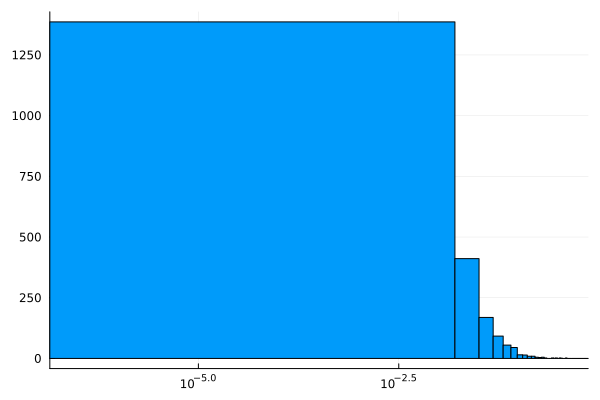

In [264]:
plot(h ; label="",xscale=:log10, xlim=extrema(b)) #  yscale=:log10, ylims=(0.1,:auto)

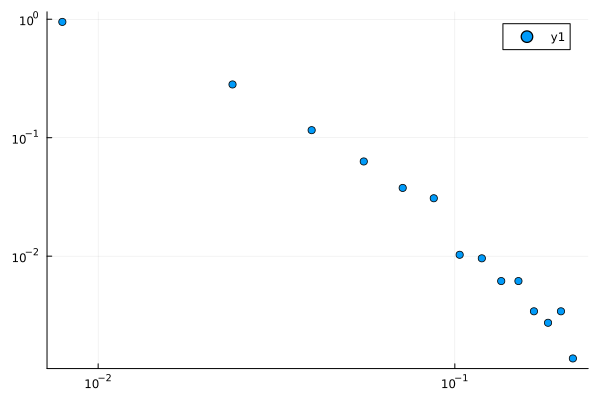

In [268]:
scatter(x_nozero,y_nozero_norm,xscale=:log10,yscale=:log10)

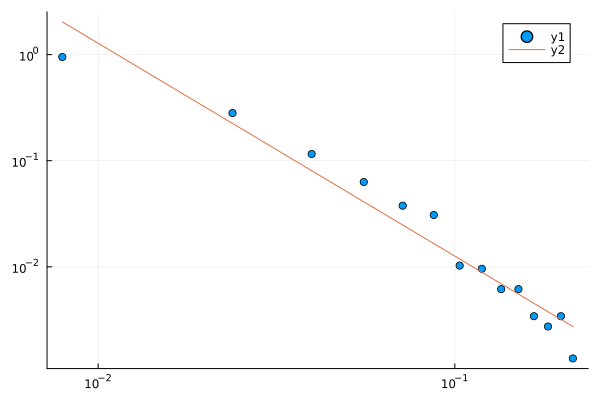

In [327]:
parameters = CurveFit.power_fit(x_nozero, y_nozero_norm)

scatter(x_nozero, y_nozero_norm,xscale=:log10,yscale=:log10)
plot!(x_nozero,power_law(x_nozero,parameters[1],parameters[2]))